# Importing required modules

In [147]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community as nx_community
import numpy as np
import math
import pandas as pd

# Reading In the File

In [202]:
file_path = './final-edgelist-latlon-gephi.gml'

# Read the graph from the GML file
G = nx.read_gml(file_path)

G.edges.data('weight')

# Need to turn id to name
# Load the CSV file into a DataFrame
station_info_df = pd.read_csv('BikeshareStreetName.csv', encoding='latin1')


def add_station_name_attribute(Gr, nodeLabel, nodeStreetName):
    for node, attrs in Gr.nodes(data=True):
    # Check if 'label' attribute exists for the node
        if node == str(nodeLabel):
            nx.set_node_attributes(G, {node: nodeStreetName}, 'Station_Name')
            break

            
# Update nodes in G with the station name
for index, row in station_info_df.iterrows():
    nodeLabel = row['station_id']
    nodeStreetName = row['Start Station Name']

    add_station_name_attribute(G, nodeLabel, nodeStreetName)
    

# Weighted Degree Calculation 

To Find High traffic Nodes

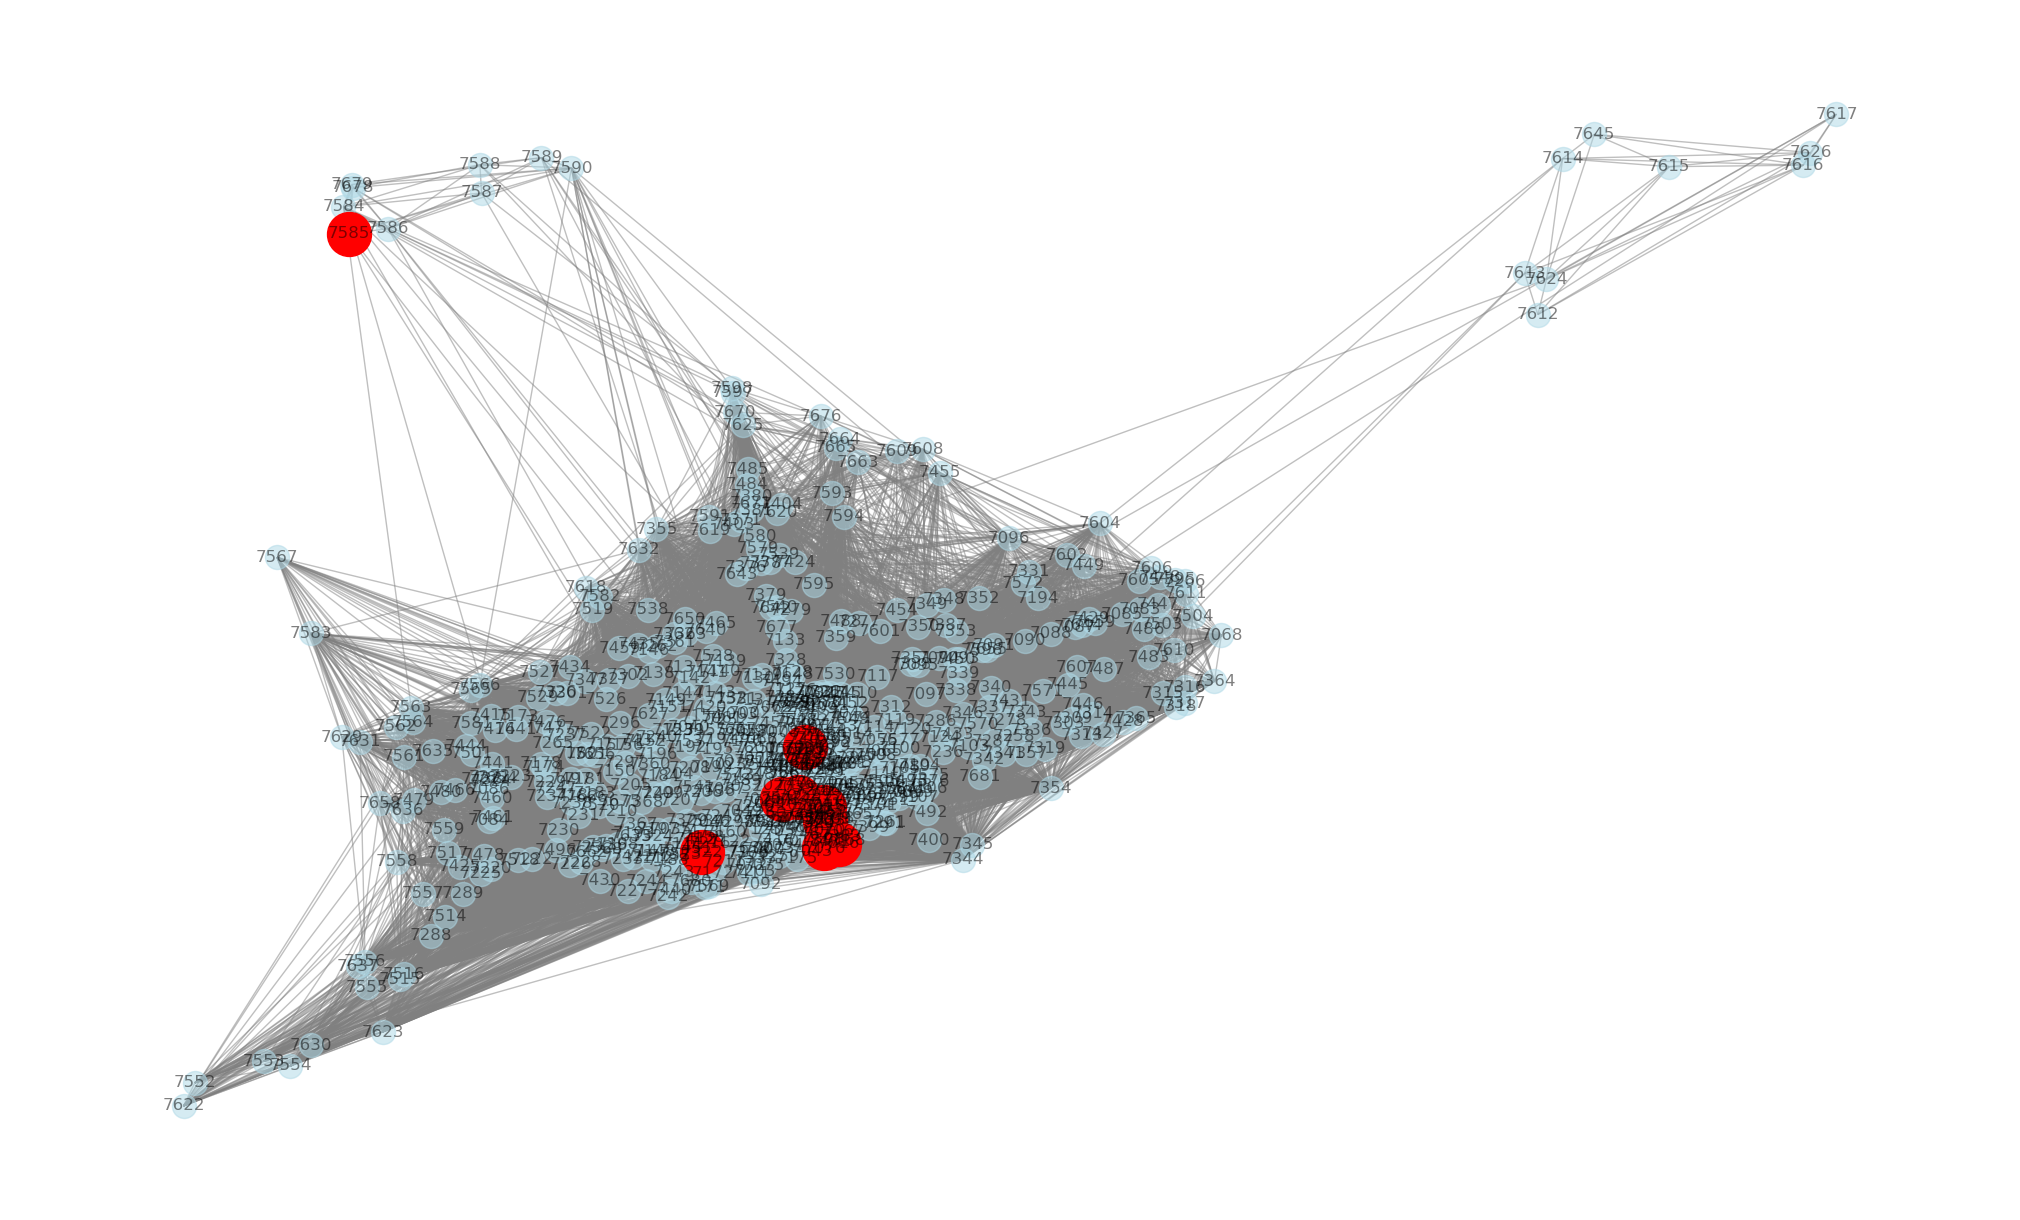

Node: 7585, Station Name: Sentinel Rd / Finch Hydro Corridor, Average Traffic: 29.50
Node: 7076, Station Name: York St / Queens Quay W, Average Traffic: 28.39
Node: 7033, Station Name: Union Station, Average Traffic: 22.49
Node: 7006, Station Name: Bay St / College St (East Side), Average Traffic: 21.65
Node: 7015, Station Name: King St W / Bay St (West Side), Average Traffic: 20.51
Node: 7322, Station Name: King St W / Brant St, Average Traffic: 19.83
Node: 7022, Station Name: Simcoe St / Queen St W, Average Traffic: 19.54
Node: 7542, Station Name: Queen St W / John St, Average Traffic: 19.12
Node: 7016, Station Name: Bay St / Queens Quay W (Ferry Terminal), Average Traffic: 19.02


In [217]:

G1 = G.copy()
# Calculate weighted degrees
weighted_degrees = dict(nx.degree(G1, weight='weight'))

potential_stations = []

#level of average traffic volume per connection
# Need to decide using average the capacity of the bike stations 
threshold = 19

for node in G1.nodes():
    # Calculate the average weight per connection
    average_weight_per_connection = weighted_degrees[node] / G1.degree(node)
    if average_weight_per_connection > threshold:
        potential_stations.append(node)

pos = {node: (G1.nodes[node]['lon'], G1.nodes[node]['lat']) for node in G1.nodes()}

# Draw the graph with geographical positions
plt.figure(figsize=(20, 12))
nx.draw(G1, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray', alpha=0.5)

# Draw potential stations with a different color
nx.draw_networkx_nodes(G1, pos, nodelist=potential_stations, node_color='red', node_size=1000)

plt.show()

# Set attribute for potential stations in G1
for node in potential_stations:
    G1.nodes[node]['is_potential_station'] = True

# Nodes not in potential_stations are explicitly set to False
for node in G1.nodes():
    if node not in potential_stations:
        G1.nodes[node]['is_potential_station'] = False
        

# Adjust the calculation for average_weight_per_connection to include only potential stations and then sort and print them
potential_stations_with_avg_traffic = []
for node in potential_stations:
    average_weight_per_connection = weighted_degrees[node] / G1.degree(node)
    potential_stations_with_avg_traffic.append((node, average_weight_per_connection))

# Sort potential stations by their average traffic in descending order
sorted_potential_stations = sorted(potential_stations_with_avg_traffic, key=lambda x: x[1], reverse=True)

# Print sorted potential stations with their Station_Name and average traffic
for node, avg_traffic in sorted_potential_stations:
    print(f"Node: {node}, Station Name: {G1.nodes[node]['Station_Name']}, Average Traffic: {avg_traffic:.2f}")



Display Potential stations

# High-Weight Edges

Find Popular Routes

In [207]:
#Adding distance to the graph

# the Haversine formula
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    # Radius of Earth in kilometers. Use 3956 for miles
    r = 6371
    return c * r

for u, v in G.edges():
    node_u_lat, node_u_lon = G.nodes[u]['lat'], G.nodes[u]['lon']
    node_v_lat, node_v_lon = G.nodes[v]['lat'], G.nodes[v]['lon']
    distance = calculate_distance(node_u_lat, node_u_lon, node_v_lat, node_v_lon)
    G[u][v]['distance'] = distance
    

nx.write_gml(G, "final-edgelist-WithDistance-gephi.gml")


Display Popular Routes 

top_percent_index 3458
Weight threshold for top 5% of routes: 32
Max distance =  28.84223153616353
Min distance =  0.011601563589816405


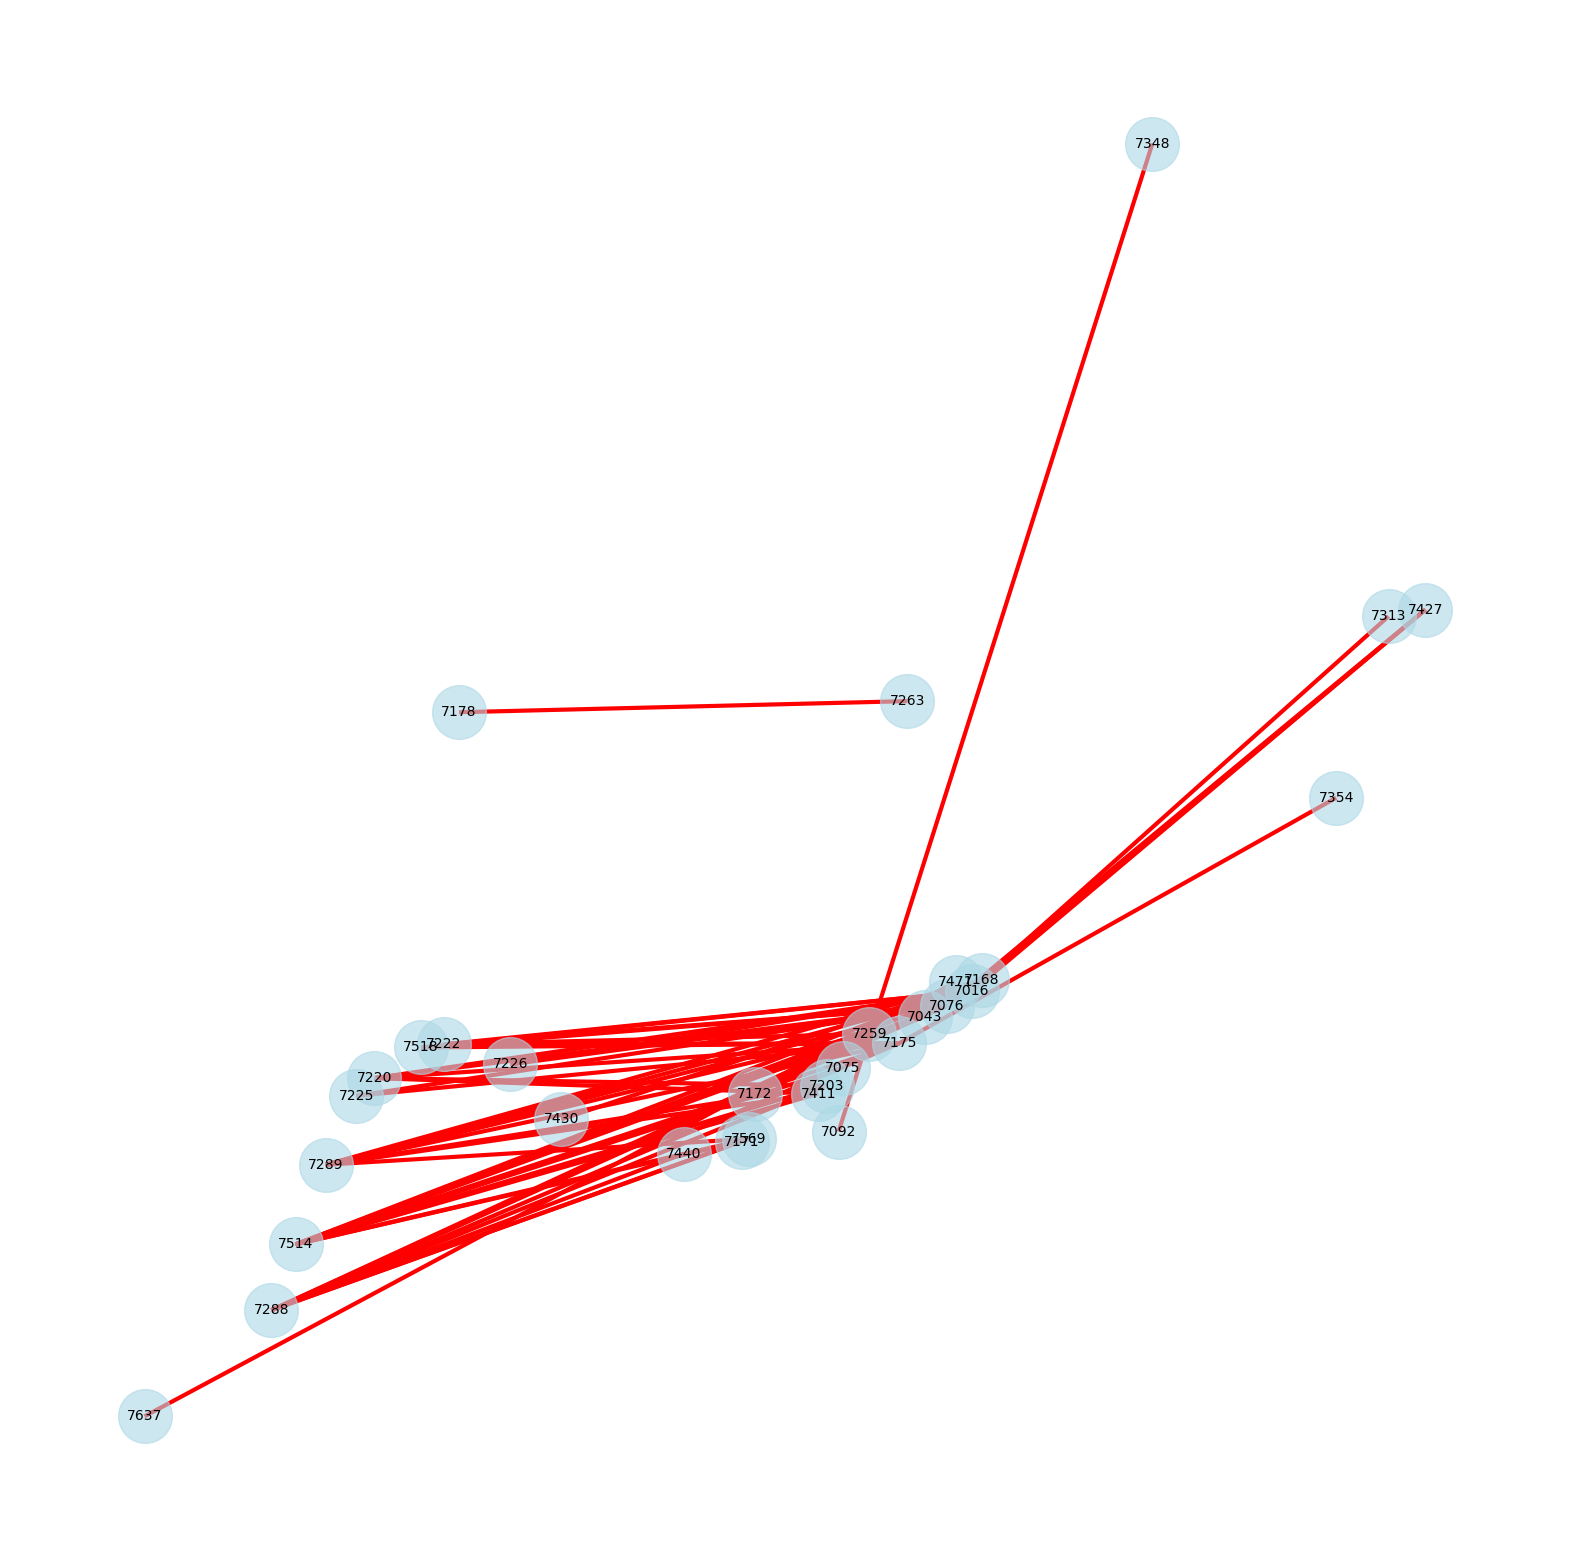

Node: 7076, Station Name: York St / Queens Quay W, Total Weight: 9192
Node: 7033, Station Name: Union Station, Total Weight: 6175
Node: 7006, Station Name: Bay St / College St (East Side), Total Weight: 5818
Node: 7015, Station Name: King St W / Bay St (West Side), Total Weight: 5350
Node: 7016, Station Name: Bay St / Queens Quay W (Ferry Terminal), Total Weight: 4909


In [213]:
edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]

#Sort weights in descending order
sorted_weights = sorted(edge_weights, reverse=True)

# cut-off for the top x%
percent =  0.05
num_edges = len(sorted_weights)
top_percent_index = int(num_edges * percent) - 1  
weight_threshold = sorted_weights[top_percent_index]

print(f"top_percent_index {top_percent_index}")
print(f"Weight threshold for top {int(percent * 100)}% of routes: {weight_threshold}")

H = G.copy()

# Add an attribute to edges indicating if they are popular routes or not
for u, v, data in H.edges(data=True):
    if data['weight'] > weight_threshold:
        H[u][v]['popular'] = True
    else:
        H[u][v]['popular'] = False

# Filter edges by the 'popular' attribute and collect the nodes connected by these edges
popular_edges = [(u, v) for u, v, data in H.edges(data=True) if data.get('popular')]
popular_nodes = set([node for edge in popular_edges for node in edge])

pos_geo = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}


# Extract all distance values from the graph
distances = [data['distance'] for u, v, data in H.edges(data=True)]

distance_threshold = 5

# Filter edges not only by the 'popular' attribute but also by distance above the threshold
popular_and_distance_edges = [(u, v) for u, v, data in H.edges(data=True) if data.get('popular') and data.get('distance', 0) >= distance_threshold]

# Create a subgraph with these filtered edges
H_sub = nx.Graph()
H_sub.add_edges_from(popular_and_distance_edges, weight=data['weight'])

# Re-calculate positions for nodes in this new subgraph to ensure we only include relevant nodes
pos_geo_sub = {node: pos_geo[node] for node in H_sub.nodes()}

# Redrawing the graph
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed

# Draw only nodes connected by popular routes and above the distance threshold
nx.draw_networkx_nodes(H_sub, pos_geo_sub, node_size=1500, node_color='lightblue', alpha=0.6)

# Draw only popular routes above the distance threshold
nx.draw_networkx_edges(H_sub, pos_geo_sub, edgelist=popular_and_distance_edges, width=3, edge_color='red')

# Optional: If you want to display labels for these nodes as well
nx.draw_networkx_labels(H_sub, pos_geo_sub, font_size=10)

plt.axis('off')
plt.show()

for u, v in popular_and_distance_edges:
    weight = H[u][v]['weight']  # Get the weight from the original graph H
    distance = H[u][v]['distance']  # Get the distance from the original graph H
    H_sub.add_edge(u, v, weight=weight, distance=distance)

for node in H_sub.nodes():
    H_sub.nodes[node]['lon'] = pos_geo[node][0]  # Assign longitude
    H_sub.nodes[node]['lat'] = pos_geo[node][1]  # Assign latitude

    if 'Station_Name' in H.nodes[node]:  # Check if the street name exists in the original node
        H_sub.nodes[node]['Station_Name'] = H.nodes[node]['Station_Name']
    


# Calculate the total weight of popular edges for each node
node_total_weight = {node: 0 for node in G.nodes()}
for u, v, data in H.edges(data=True):
    if data.get('popular'):
        node_total_weight[u] += data['weight']
        node_total_weight[v] += data['weight']

# Sort nodes by their total weight of connected popular edges in descending order
sorted_nodes_by_weight = sorted(node_total_weight.items(), key=lambda x: x[1], reverse=True)

# Print the top five nodes, their Station Name, and the total weight of their connected popular edges
for node, total_weight in sorted_nodes_by_weight[:5]:
    print(f"Node: {node}, Station Name: {G.nodes[node]['Station_Name']}, Total Weight: {total_weight}")
    
nx.write_gml(H_sub, "final-edgelist-HighTrafficNodes-gephi.gml")


# Community Detection

In [40]:
#Detect the community with highest modularity
def detect_best_community_with_networkx(G, iterations=1000):
    max_modularity = None
    best_communities = None
    for _ in range(iterations):
        communities_generator = nx_community.louvain_communities(G)
        communities = list(communities_generator)
        modularity = nx_community.modularity(G, communities)
        if max_modularity is None or modularity > max_modularity:
            max_modularity = modularity
            best_communities = communities
    return best_communities, max_modularity


communities, best_modularity = detect_best_community_with_networkx(G, 1000)


KeyboardInterrupt: 

Community 1: Size = 162, Average Weight = 9.85966157851142
Community 2: Size = 107, Average Weight = 17.09942196531792
Community 3: Size = 73, Average Weight = 21.148353827846094
Community 4: Size = 49, Average Weight = 7.78135593220339
Community 5: Size = 123, Average Weight = 6.731863898994222
Community 6: Size = 44, Average Weight = 33.94109396914446
Community 7: Size = 9, Average Weight = 10.185185185185185
Partition values: {'7655': 0, '7194': 0, '7373': 0, '7317': 0, '7065': 0, '7269': 0, '7083': 0, '7095': 0, '7291': 0, '7090': 0, '7104': 0, '7681': 0, '7337': 0, '7644': 0, '7110': 0, '7383': 0, '7056': 0, '7492': 0, '7443': 0, '7486': 0, '7107': 0, '7489': 0, '7287': 0, '7303': 0, '7551': 0, '7168': 0, '7106': 0, '7508': 0, '7493': 0, '7336': 0, '7094': 0, '7448': 0, '7487': 0, '7050': 0, '7261': 0, '7351': 0, '7085': 0, '7109': 0, '7100': 0, '7236': 0, '7575': 0, '7103': 0, '7315': 0, '7454': 0, '7450': 0, '7286': 0, '7318': 0, '7607': 0, '7429': 0, '7406': 0, '7313': 0, '7088

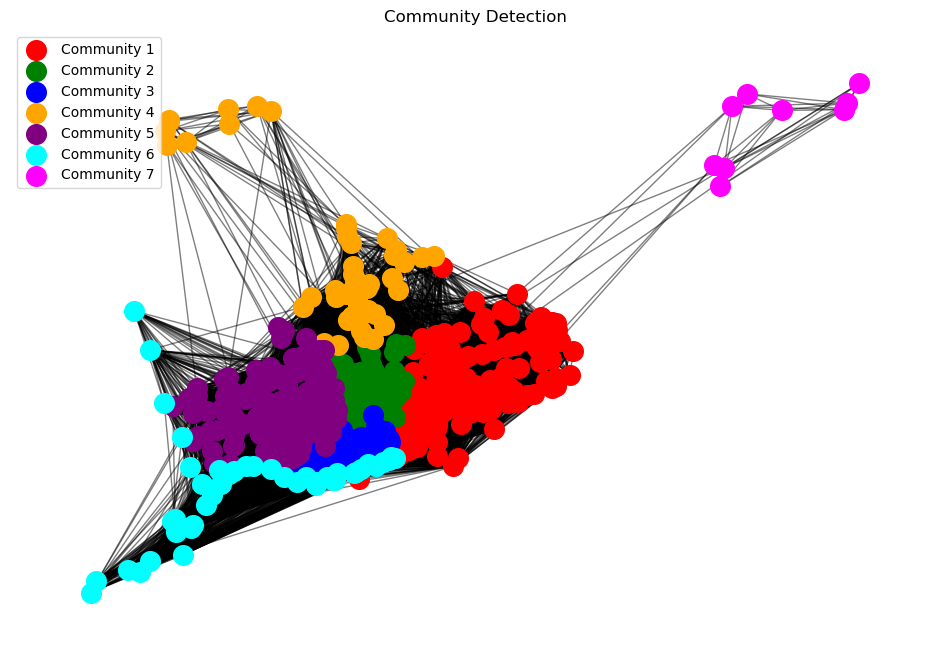

comModularity =  0.27522633489979004


In [121]:
#Community info

# Create a dictionary to map nodes to community index
node_community_map = {}
for i, community in enumerate(communities):
    for node in community:
        node_community_map[node] = i

# Analyze community characteristics with average weight
for i, community in enumerate(communities):
    # Initialize total weight and edge count
    total_weight = 0
    edge_count = 0
    
    # Iterate through each node in the community
    for node in community:
        # For each node, look at each of its neighbors
        for neighbor, edge_attrs in G[node].items():
            # If the neighbor is also in the community, add the edge's weight
            if neighbor in community:
                # Assume the weight attribute is named 'weight', adjust if it's named differently
                total_weight += edge_attrs.get('weight', 1)  # Default to 1 if no weight
                edge_count += 1

    # To avoid double counting edges, divide total weight and edge count by 2 for undirected graphs
    if not G.is_directed():
        total_weight /= 2
        edge_count /= 2

    # Calculate average weight if there are any edges
    average_weight = total_weight / edge_count if edge_count else 0
    
    print(f"Community {i+1}: Size = {len(community)}, Average Weight = {average_weight}")

# Create a dictionary to map nodes to community index
partition = {}
for i, community in enumerate(communities):
    for node in community:
        partition[node] = i

print("Partition values:", partition)

#add the attributes to the graph 
nx.set_node_attributes(G, partition, name='community')


# Draw the graph with nodes colored by community
# Layout algorithm using geographic coordinates
pos = {node: (G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes()}

# Define colors for each community
community_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta']


plt.figure(figsize=(12, 8))
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=community_colors[i], node_size=200, label=f"Community {i+1}")
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Community Detection')
plt.legend()
plt.axis('off')
plt.show()

nx.write_gml(G, "final-edgelist-Community-gephi.gml")

comModularity = nx_community.modularity(G, communities)
print("comModularity = ", comModularity)